In [20]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pdb

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import mutual_info_regression

from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import ExtraTreesRegressor

from keras.models import Sequential
from keras.layers import Dense
from sklearn.neural_network import MLPRegressor

from sklearn.model_selection import GridSearchCV

# load the written function for RMSE, linear and ridge regression

In [61]:
def rmse(y_pred,y):
    return np.sqrt(mean_squared_error(y_pred,y))
                   
def linear_regressionGD(x,y,lr=0.05,n_iter=10000):
    
    cost = []
    phi0 = np.zeros((x.shape[0],1))
    phi_n = np.zeros((x.shape[1],1))
    m = x.shape[0]
    
    for _ in range(n_iter):
        y_pred = np.dot(x,phi_n) + phi0
        res = y_pred - y
        g_phi0 = np.sum(res)/m
        phi0 = phi0 - lr*g_phi0
        for i in range(len(phi_n)):
            g_phi = np.dot(res.T,x[:,i])/m
            phi_n[i] = phi_n[i]- lr*g_phi
    
    return phi0,phi_n

def ridgeGD(x,y,lr=0.001,pen=0.01,n_iter=10000):
    cost = []
    
    phi = np.zeros((x.shape[1],1))
    m = x.shape[0]
    
    for _ in range(n_iter):
        y_pred = np.dot(x,phi)
        res = y_pred - y
        for i in range(len(phi)):
            g_phi = (np.dot(res.T,x[:,i]) + pen * phi[i]) / m
            phi[i] = phi[i] * (1 - pen * lr / m) - lr * np.dot(res.T,x[:,i]) / m
            
    #y_pred = np.dot(x,phi)
    return phi

In [3]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")
train.drop(['Customer ID','Name'],axis=1,inplace=True)

# Missing data and outliers checking

In [4]:
train.isna().sum().sort_values(ascending=False)/len(train)

Type of Employment             0.242370
Property Age                   0.162185
Income (USD)                   0.153074
Dependents                     0.083000
Credit Score                   0.056556
Income Stability               0.055778
Has Active Credit Card         0.052778
Property Location              0.011370
Loan Amount                    0.010926
Current Loan Expenses (USD)    0.005926
Gender                         0.001593
Property Price                 0.000000
Expense Type 1                 0.000000
No. of Defaults                0.000000
Loan Amount Request (USD)      0.000000
Location                       0.000000
Property ID                    0.000000
Profession                     0.000000
Property Type                  0.000000
Co-Applicant                   0.000000
Age                            0.000000
Expense Type 2                 0.000000
dtype: float64

In [5]:
(train==-999).sum().sort_values(ascending=False)/len(train)

Property Price                 0.011593
Loan Amount                    0.011148
Current Loan Expenses (USD)    0.006111
Co-Applicant                   0.005556
Expense Type 1                 0.000000
Age                            0.000000
Income (USD)                   0.000000
Income Stability               0.000000
Profession                     0.000000
Type of Employment             0.000000
Location                       0.000000
Loan Amount Request (USD)      0.000000
Expense Type 2                 0.000000
Dependents                     0.000000
Credit Score                   0.000000
No. of Defaults                0.000000
Has Active Credit Card         0.000000
Property ID                    0.000000
Property Age                   0.000000
Property Type                  0.000000
Property Location              0.000000
Gender                         0.000000
dtype: float64

In [106]:
test.isna().sum().sort_values(ascending=False)/len(test)

Property Price                 0.0
Current Loan Expenses (USD)    0.0
Name                           0.0
Gender                         0.0
Age                            0.0
Income (USD)                   0.0
Income Stability               0.0
Profession                     0.0
Type of Employment             0.0
Location                       0.0
Loan Amount Request (USD)      0.0
Expense Type 1                 0.0
Co-Applicant                   0.0
Expense Type 2                 0.0
Dependents                     0.0
Credit Score                   0.0
No. of Defaults                0.0
Has Active Credit Card         0.0
Property ID                    0.0
Property Age                   0.0
Property Type                  0.0
Property Location              0.0
Customer ID                    0.0
dtype: float64

In [105]:
(test==-999).sum().sort_values(ascending=False)/len(test)

Property Price                 0.0
Current Loan Expenses (USD)    0.0
Name                           0.0
Gender                         0.0
Age                            0.0
Income (USD)                   0.0
Income Stability               0.0
Profession                     0.0
Type of Employment             0.0
Location                       0.0
Loan Amount Request (USD)      0.0
Expense Type 1                 0.0
Co-Applicant                   0.0
Expense Type 2                 0.0
Dependents                     0.0
Credit Score                   0.0
No. of Defaults                0.0
Has Active Credit Card         0.0
Property ID                    0.0
Property Age                   0.0
Property Type                  0.0
Property Location              0.0
Customer ID                    0.0
dtype: float64

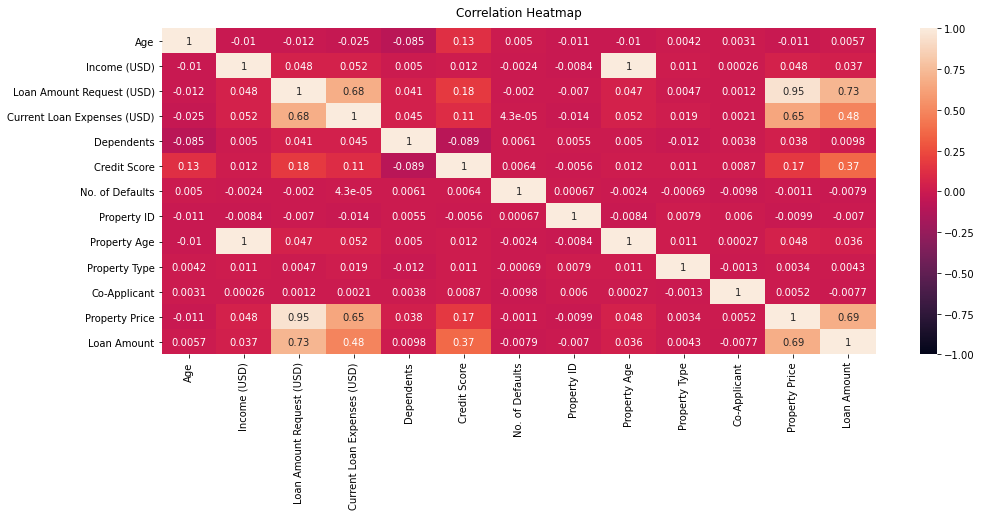

In [8]:
plt.figure(figsize=(16, 6))
a = train.dropna().copy()
heatmap = sns.heatmap(train.corr(), vmin=-1, vmax=1, annot=True)
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12);

# Data pre-processing and cleaning

In [9]:
lq = train['Loan Amount'].quantile(0.02)
lq2 = train['Current Loan Expenses (USD)'].quantile(0.02)
lq3 = train['Property Price'].quantile(0.0001)
                                
train=train[train['Property Price']>lq3]

train.drop(train[train['Current Loan Expenses (USD)'] == -999].index,inplace =True)
train=train[train['Loan Amount']>lq]

In [104]:
numerics = ['int','int16', 'int32', 'int64', 'float16', 'float32', 'float64','float']

train_con_col = train.select_dtypes(include = numerics).columns
train_cat_col = train.select_dtypes(include = "object").columns
test_con_col = test.select_dtypes(include = numerics).columns
test_cat_col = test.select_dtypes(include = "object").columns


#imputation for continuous test dataset value
for col in train[train_con_col]:
    upper_lim = train[col].quantile(.95)
    lower_lim = train[col].quantile(.05)

    data = train[(train[col] < upper_lim) & (train[col] > lower_lim)]
    imputation_value = data[col].mean()
    
    train[col].fillna(value=imputation_value,inplace = True)
    train[col] = train[col].replace(-999,imputation_value)


for col in train[train_cat_col]:
    train[col].fillna(value="No",inplace = True)
    train[col] = LabelEncoder().fit_transform(train[col])
    
for col in test[test_con_col]:
    upper_lim = test[col].quantile(.95)
    lower_lim = test[col].quantile(.05)

    data = test[(test[col] < upper_lim) & (test[col] > lower_lim)]
    imputation_value = data[col].mean()
    
    test[col].fillna(value=imputation_value,inplace = True)
    test[col] = test[col].replace(-999,imputation_value)

for col in test[test_cat_col]:
    test[col].fillna(value="No",inplace = True)

train["Co-Applicant"].fillna(value=1,inplace = True)
train['Dependents'] = round(train['Dependents'])
test["Co-Applicant"].fillna(value=1,inplace = True)
test['Dependents'] = round(test['Dependents'])

# Features plottings

Training size: (18940, 22)


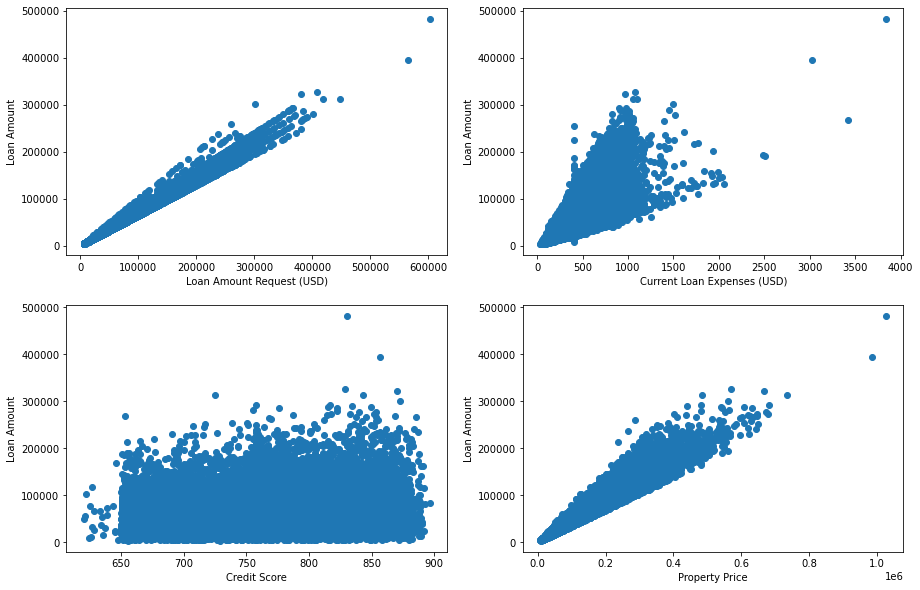

<Figure size 720x576 with 0 Axes>

In [11]:
fig, axs = plt.subplots(2, 2,figsize=(15,10))
plt.figure(figsize=(10,8))

print('Training size:',train.shape)
axs[0][0].scatter(train['Loan Amount Request (USD)'],train['Loan Amount'])
axs[0][0].set_xlabel('Loan Amount Request (USD)')
axs[0][0].set_ylabel('Loan Amount')

axs[0][1].scatter(train['Current Loan Expenses (USD)'],train['Loan Amount'])
axs[0][1].set_xlabel('Current Loan Expenses (USD)')
axs[0][1].set_ylabel('Loan Amount')

axs[1][0].scatter(train['Credit Score'],train['Loan Amount'])
axs[1][0].set_xlabel('Credit Score')
axs[1][0].set_ylabel('Loan Amount')

axs[1][1].scatter(train['Property Price'],train['Loan Amount'])
axs[1][1].set_xlabel('Property Price')
axs[1][1].set_ylabel('Loan Amount')

plt.show()

# Mutual information measurement

In [14]:
y = train['Loan Amount'].to_numpy()
mi_scores_cat = mutual_info_regression(train[train_con_col].to_numpy(),y)
mi_scores_cat = pd.Series(mi_scores_cat, name="MI Scores", index=train[train_con_col].columns)
mi_scores_cat = mi_scores_cat.sort_values(ascending=False)
mi_scores_cat

Loan Amount                    8.592720
Loan Amount Request (USD)      6.046824
Property Price                 1.471151
Current Loan Expenses (USD)    0.686093
Property Age                   0.078006
Income (USD)                   0.077937
Credit Score                   0.028583
Property ID                    0.003378
Dependents                     0.002412
No. of Defaults                0.000960
Co-Applicant                   0.000000
Property Type                  0.000000
Age                            0.000000
Name: MI Scores, dtype: float64

In [15]:
mi_scores_cat = mutual_info_regression(train[train_cat_col].to_numpy(),y)
mi_scores_cat = pd.Series(mi_scores_cat, name="MI Scores", index=train[train_cat_col].columns)
mi_scores_cat = mi_scores_cat.sort_values(ascending=False)
mi_scores_cat

Location                  0.014076
Has Active Credit Card    0.009477
Profession                0.008389
Gender                    0.004695
Expense Type 1            0.003905
Expense Type 2            0.003026
Type of Employment        0.003004
Property Location         0.001268
Income Stability          0.000000
Name: MI Scores, dtype: float64

# MinMax-Normalization

In [57]:
x_scaler = MinMaxScaler()
x = train[['Loan Amount Request (USD)','Current Loan Expenses (USD)','Credit Score','Property Price']].to_numpy() 
x_scaled = x_scaler.fit_transform(x)
y = train[['Loan Amount']].to_numpy()

# Linear regression

           RMSE  learning_rate
0   6586.843581            0.1
1   5980.058065            0.2
2   5665.859657            0.3
3   5499.884047            0.4
4   5413.213383            0.5
5   5368.393035            0.6
6   5345.346304            0.7
7   5333.531805            0.8
8   5327.485024            0.9
9   5324.392814            1.0
10  5322.812213            1.1
11  5322.004472            1.2
12  5321.591743            1.3
13  5321.380869            1.4
14  5321.273133            1.5


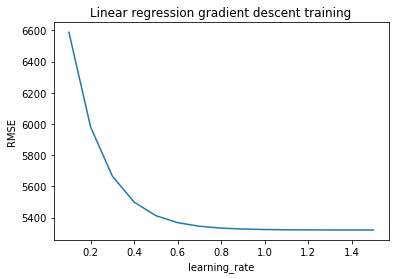

In [60]:
lr_set = np.linspace(0.1,1.5,15)
lrgd_rmse_list = []

for lr_rate in lr_set:
    lr_phi0,lr_phi_n = linear_regressionGD(x_scaled,y,lr=lr_rate,n_iter=10000)
    y_pred = np.dot(x_scaled,lr_phi_n) + lr_phi0
    lrgd_rmse_list.append(rmse(y_pred,y))

linear_reg_rmse = pd.DataFrame(zip(lrgd_rmse_list,lr_set),columns=['RMSE','learning_rate'])
print(linear_reg_rmse)

plt.plot(lr_set,lrgd_rmse_list)
plt.title('Linear regression gradient descent training')
plt.xlabel('learning_rate')
plt.ylabel('RMSE')
plt.show()

# Ridge regression

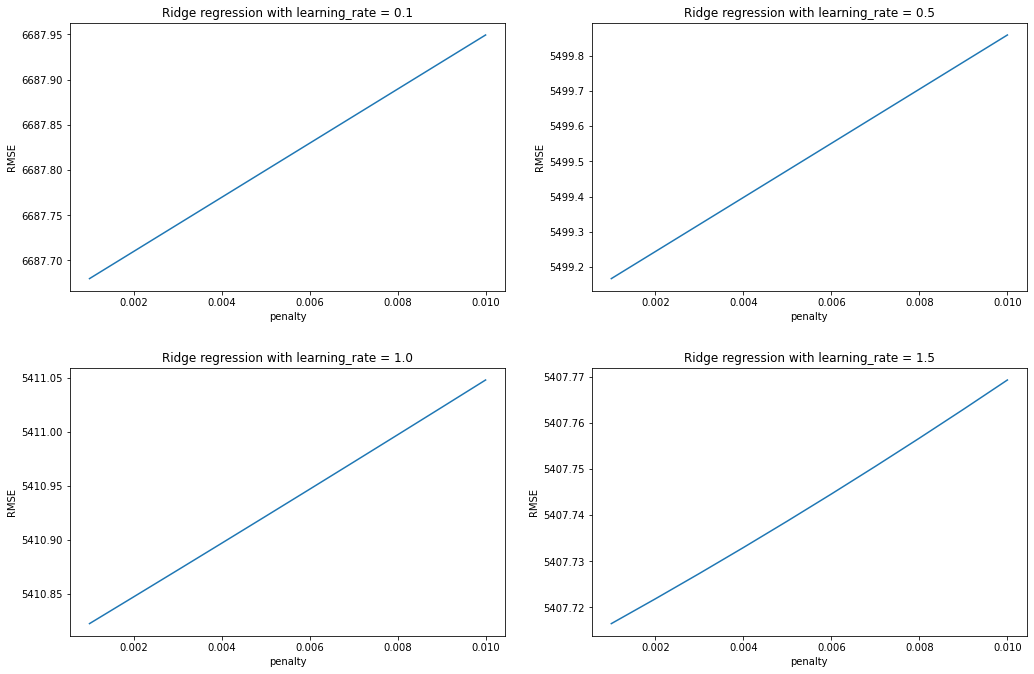

In [62]:
ridge_lr_test_set = np.array([0.1,0.5,1.0,1.5])
pen_set = np.linspace(0.001,0.01,10)
ridge_rmse_list = []


fig, axs = plt.subplots(2, 2,figsize=(15,10))
for lr_rate,ax in zip(ridge_lr_test_set,axs.ravel()):
    ridge_rmse=[]
    for p in pen_set:
        ridge_phi = ridgeGD(x_scaled,y,lr=lr_rate,pen=p,n_iter=10000)
        y_pred = np.dot(x_scaled,ridge_phi)
        ridge_rmse.append(rmse(y_pred,y))
    ax.ticklabel_format(useOffset=False)
    ax.plot(pen_set,ridge_rmse)
    ax.set_title('Ridge regression with learning_rate = {}'.format(lr_rate))
        #ax.get_legend().remove()
    ax.set_xlabel("")
    ax.figure.tight_layout(pad=3.0)
    ax.set_ylabel("RMSE")
    ax.set_xlabel("penalty")

           RMSE        lr
0   5499.858468  0.500000
1   5452.960745  0.607143
2   5429.923007  0.714286
3   5418.622290  0.821429
4   5413.073626  0.928571
5   5410.341501  1.035714
6   5408.989900  1.142857
7   5408.316663  1.250000
8   5407.978117  1.357143
9   5407.805679  1.464286
10  5407.716365  1.571429
11  5407.669118  1.678571
12  5407.643478  1.785714
13  5407.629149  1.892857
14  5407.620884  2.000000


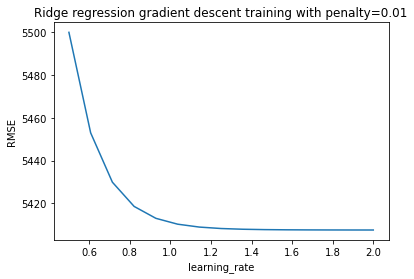

In [151]:
ridge_rmse=[]
ridge_lr_set = np.linspace(0.5,2,15)

for lr_rate in ridge_lr_set:
    ridge_phi = ridgeGD(x_scaled,y,lr=lr_rate,pen=0.01,n_iter=10000)
        #ridge_rmse_list.append([rmse(y_pred,y),lr_rate,p])
    y_pred = np.dot(x_scaled,ridge_phi)
    ridge_rmse.append(rmse(y_pred,y))

ridge_rmse_df = pd.DataFrame(zip(ridge_rmse,ridge_lr_set),columns=['RMSE','lr'])
print(ridge_rmse_df)

plt.plot(ridge_lr_set,ridge_rmse)
plt.title('Ridge regression gradient descent training with penalty=0.01')
plt.xlabel('learning_rate')
plt.ylabel('RMSE')
plt.show()

# Other models

In [152]:
knn_reg = KNeighborsRegressor()
dt_reg = DecisionTreeRegressor()
rf_reg = RandomForestRegressor()
et_reg = ExtraTreesRegressor()
sv_reg = SVR()
xgb_reg = XGBRegressor()


reg = [knn_reg,dt_reg,rf_reg,et_reg,sv_reg,xgb_reg]
reg_name = ["KNeighborsRegressor","DecisionTreeRegressor","RandomForestRegressor","ExtraTreesRegressor","SupportVectorRegressor",'XGBRegressor']

x_scaler = MinMaxScaler()
x = train[['Loan Amount Request (USD)','Current Loan Expenses (USD)','Credit Score','Property Price']].to_numpy() 
x_scaled = x_scaler.fit_transform(x)
y = train[['Loan Amount']].to_numpy()

X_train, X_test, y_train, y_test = train_test_split(x_scaled, y, test_size=0.33, random_state=42)
np.random.seed(42)
y_train = y_train.reshape(y_train.shape[0],)

train_rmse_list = []
test_rmse_list = []

for model,name in zip(reg,reg_name):
    
    model.fit(X_train,y_train)
    
    y_test_pred = model.predict(X_test)
    y_test_pred = y_test_pred.reshape(y_test_pred.shape[0],)
    
    y_train_pred = model.predict(X_train)
    y_train_pred = y_train_pred.reshape(y_train_pred.shape[0],)
    
    test_rmse_list.append(rmse(y_test_pred,y_test))
    train_rmse_list.append(rmse(y_train_pred,y_train))
    print("Model:{} , train_RMSE: {:.4f} , test_RMSE: {:.4f}".format(name,rmse(y_train_pred,y_train),rmse(y_test_pred,y_test)))
                     
model_df = pd.DataFrame(zip(reg_name,train_rmse_list,test_rmse_list),columns=['Model','train_RMSE','test_RMSE'])
model_df = model_df.round(5)
model_df

Model:KNeighborsRegressor , train_RMSE: 4641.5865 , test_RMSE: 6428.5351
Model:DecisionTreeRegressor , train_RMSE: 0.0000 , test_RMSE: 6926.0600
Model:RandomForestRegressor , train_RMSE: 1838.4934 , test_RMSE: 5311.5124
Model:ExtraTreesRegressor , train_RMSE: 0.0000 , test_RMSE: 5259.1123
Model:SupportVectorRegressor , train_RMSE: 44942.0405 , test_RMSE: 45771.1474
Model:XGBRegressor , train_RMSE: 2813.3577 , test_RMSE: 5244.6099


,Model,train_RMSE,test_RMSE
0,KNeighborsRegressor,4641.58646,6428.53512
1,DecisionTreeRegressor,0.00000,6926.06000
2,RandomForestRegressor,1838.49335,5311.51236
3,ExtraTreesRegressor,0.00000,5259.11233
4,SupportVectorRegressor,44942.04052,45771.14740
5,XGBRegressor,2813.35768,5244.60988


In [153]:
for model,name in zip(reg,reg_name):
    score = cross_val_score(model,X_train,y_train,cv=10)
    print('Model:{}, CV score:{}\n'.format(name,score))

Model:KNeighborsRegressor, CV score:[0.98022089 0.98336029 0.9859396  0.9829462  0.98342711 0.98321909
 0.98277944 0.98661645 0.98486779 0.98315765]

Model:DecisionTreeRegressor, CV score:[0.97887121 0.97638423 0.98140488 0.97947369 0.978325   0.97552606
 0.97782362 0.98203472 0.98103892 0.97741046]

Model:RandomForestRegressor, CV score:[0.98639634 0.9876968  0.98961108 0.98822901 0.98813749 0.98782661
 0.98776464 0.98982703 0.9888616  0.98689603]

Model:ExtraTreesRegressor, CV score:[0.98582968 0.98780512 0.9893708  0.98875223 0.98834942 0.98736665
 0.98677241 0.98947854 0.98869036 0.98648598]

Model:SupportVectorRegressor, CV score:[-0.02085198 -0.02949013 -0.01535558 -0.04570864 -0.01743576 -0.01531443
 -0.01795535 -0.01165319 -0.00377204 -0.00229024]

Model:XGBRegressor, CV score:[0.98408893 0.98804732 0.98932266 0.98776932 0.98836522 0.98803725
 0.98738262 0.98927901 0.98961114 0.98731061]



# DNN model

In [77]:
dnn_model = Sequential()
dnn_model.add(Dense(256, input_dim=x.shape[1], activation='relu'))
dnn_model.add(Dense(256, activation='relu'))
dnn_model.add(Dense(256, activation='relu'))
dnn_model.add(Dense(256, activation='relu'))
dnn_model.add(Dense(256, activation='relu'))
dnn_model.add(Dense(256, activation='relu'))
dnn_model.add(Dense(1, activation='linear'))

dnn_model.compile(loss='mean_squared_error', optimizer='adam',metrics=['mean_absolute_error'])
dnn_model.fit(X_train, y_train, epochs=10, batch_size=16)

y_train_pred = dnn_model.predict(X_train)
y_test_pred = dnn_model.predict(X_test)

print("Train-RMSE:",rmse(y_train_pred,y_train))
print("Test-RMSE:",rmse(y_test_pred,y_test))

Epoch 1/10
794/794 [==============================] - 1s 2ms/step - loss: 552911616.0000 - mean_absolute_error: 11487.4062
Epoch 2/10
794/794 [==============================] - 1s 2ms/step - loss: 36022552.0000 - mean_absolute_error: 4098.8779
Epoch 3/10
794/794 [==============================] - 1s 2ms/step - loss: 28957190.0000 - mean_absolute_error: 3670.0078
Epoch 4/10
794/794 [==============================] - 1s 2ms/step - loss: 29937902.0000 - mean_absolute_error: 3734.1150
Epoch 5/10
794/794 [==============================] - 1s 2ms/step - loss: 28042350.0000 - mean_absolute_error: 3599.8679
Epoch 6/10
794/794 [==============================] - 1s 2ms/step - loss: 28572726.0000 - mean_absolute_error: 3610.3428
Epoch 7/10
794/794 [==============================] - 1s 2ms/step - loss: 27385054.0000 - mean_absolute_error: 3547.4697
Epoch 8/10
794/794 [==============================] - 1s 2ms/step - loss: 28003460.0000 - mean_absolute_error: 3576.8906
Epoch 9/10
794/794 [==========

In [50]:
model.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_48 (Dense)            (None, 256)               1280      
                                                                 
 dense_49 (Dense)            (None, 256)               65792     
                                                                 
 dense_50 (Dense)            (None, 256)               65792     
                                                                 
 dense_51 (Dense)            (None, 256)               65792     
                                                                 
 dense_52 (Dense)            (None, 256)               65792     
                                                                 
 dense_53 (Dense)            (None, 1)                 257       
                                                                 
Total params: 264,705
Trainable params: 264,705
Non-t

In [51]:
mlp = MLPRegressor()
regr = mlp.fit(X_train, y_train)
y_train_pred = regr.predict(X_train)
y_test_pred = regr.predict(X_test)
print("Train-RMSE:",rmse(y_train_pred,y_train))
print("Test-RMSE:",rmse(y_test_pred,y_test))

Train-RMSE: 62901.13814858215
Test-RMSE: 63327.550104739494


C:\Users\WCW20000306\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


# Export the prediction csv file

In [108]:
x_scaler = MinMaxScaler()
x_test = test[['Loan Amount Request (USD)','Current Loan Expenses (USD)','Credit Score','Property Price']].to_numpy() 
x_scaled_test = x_scaler.fit_transform(x_test)

In [147]:
for model,name in zip(reg,reg_name):
    y_pred = model.predict(x_scaled_test)
    df = test[['Customer ID']].copy()
    df['Loan Amount'] = y_pred
    file_name = '20017388D_' + name + '.csv'
    df.to_csv(file_name, index=False)

In [148]:
y_pred = np.dot(x_scaled_test,lr_phi_n) + lr_phi0[0][0]
df = test[['Customer ID']].copy()
df['Loan Amount'] = y_pred
file_name = '20017388D_LR.csv'
df.to_csv(file_name, index=False)

In [149]:
y_pred = np.dot(x_scaled_test,ridge_phi)
df = test[['Customer ID']].copy()
df['Loan Amount'] = y_pred
file_name = '20017388D_ridge.csv'
df.to_csv(file_name, index=False)